<div style="text-align: center;">
    <img src="https://www.igismap.com/wp-content/uploads/2016/06/airport_traffic_network.png" width="600" />
</div>

# 1) Flight Network Analysis  


--- 

To get starded we want to download the dateset and convert the table into the graph we will need to use for our analysis.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#let's upload the dataset
df=pd.read_csv('/Users/jacopocaldana/Desktop/Università/ADM/HW5_ADM/Airports2.csv')



In [3]:
#check for missing data
print(df.isnull().sum())

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64


Only some coordinates are missing, which is quite good for our analysis

In [4]:
def table_to_graph(df, directed=True, edge_attr=None):
    # Create a directed or undirected graph
    G = nx.DiGraph() if directed else nx.Graph()

    # Add edges and attributes
    for _, row in df.iterrows():
        source = row['Origin_airport']
        destination = row['Destination_airport']

        # Include edge attributes if specified
        attributes = {attr: row[attr] for attr in edge_attr} if edge_attr else {}
        G.add_edge(source, destination, **attributes)

    return G

In [5]:
# Convert the table to a directed graph with the distance between airports as an edge attribute (this can be changed according to our needs)
flight_graph = table_to_graph(df, directed=True, edge_attr=['Distance'])

# Print graph info
print(f"Number of nodes: {nx.number_of_nodes(flight_graph)}")
print(f"Number of edges: {nx.number_of_edges(flight_graph)}")

Number of nodes: 727
Number of edges: 36719


We now try to visualize this graph, knowing that can look messy considering the large number of nodes and edges.

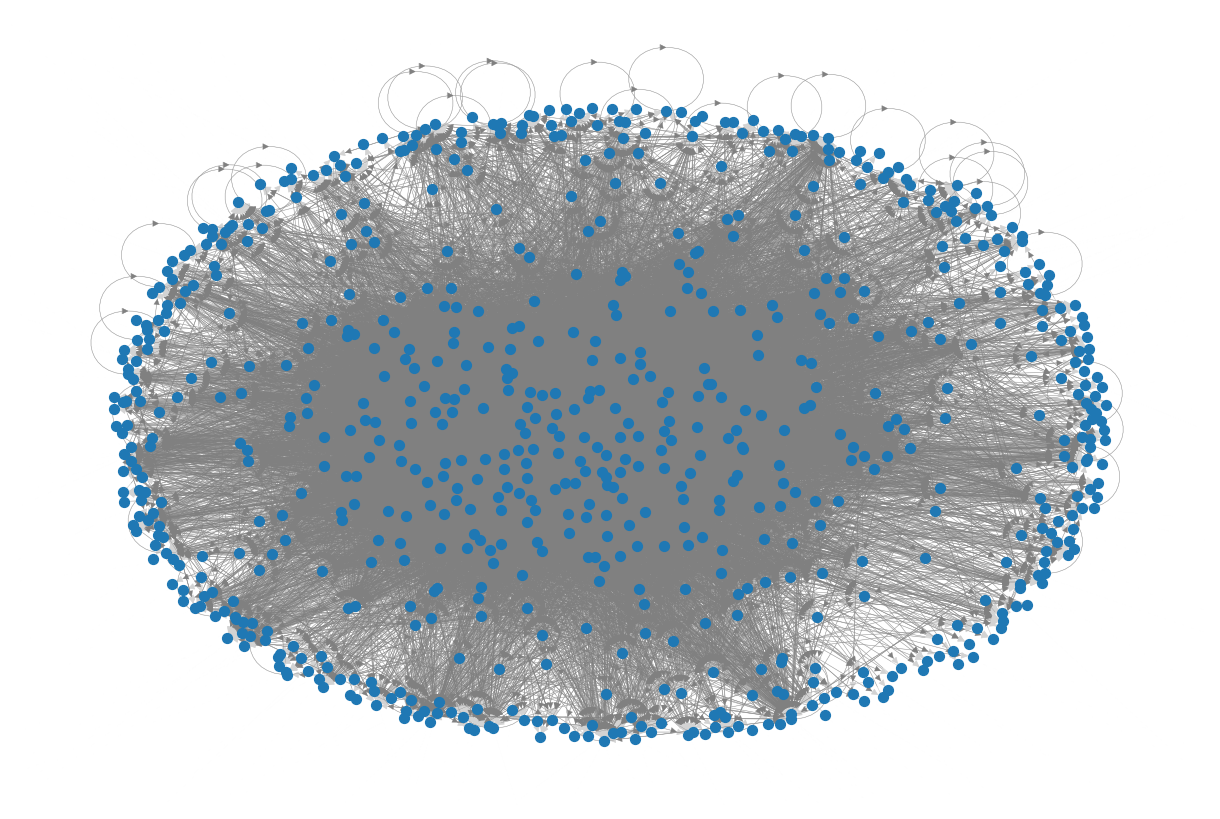

In [46]:
# Create a copy of the graph so we do not modify the original df
flight_graph_copy = flight_graph.copy()

# Invert the distance on the copy
for u, v, data in flight_graph_copy.edges(data=True):
    data['InvertedDistance'] = 1 / data['Distance'] if data['Distance'] > 0 else 1

# Use Fruchterman-Reingold layout with the inverted distance
pos = nx.spring_layout(flight_graph_copy, k=0.3, iterations=100, weight='InvertedDistance')

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(flight_graph_copy, pos, with_labels=False, node_size=50, edge_color='lightgray', width=0.5)
nx.draw_networkx_edges(flight_graph_copy, pos, edge_color='gray', width=0.2)
plt.show()

We used **Fruchterman-Reingold Algorithm** to visualize this graph, let's explain briefly how it positions the nodes in the graph:<br>
-Nodes repel each other, simulating a physical system where nodes act as charged particles.<br>
-Edges act like springs, pulling connected nodes closer together, with tension proportional to the edge weight.<br>
-Weight='InvertedDistance': Specifies that the spring forces should be scaled by the 'InvertedDistance' attribute of edges. This helps distant airports (large distances between them) be positioned farther apart.

---

## Analyze Graph Features

In [52]:
def analyze_graph_features(flight_network):
    # 1. Count the number of airports (nodes) and flights (edges)
    num_nodes = flight_network.number_of_nodes()
    num_edges = flight_network.number_of_edges()
    
    # 2. Compute the density of the graph
    density = (num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0

    # 3. Compute in-degree and out-degree for each airport
    in_degrees = [d for _, d in flight_network.in_degree()]
    out_degrees = [d for _, d in flight_network.out_degree()]

    # Visualize in-degree and out-degree distributions
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=30, color='skyblue', edgecolor='black')
    plt.title("In-Degree Distribution")
    plt.xlabel("In-Degree")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=30, color='orange', edgecolor='black')
    plt.title("Out-Degree Distribution")
    plt.xlabel("Out-Degree")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # 4. Identify hubs (airports with degrees higher than the 90th percentile)
    all_degrees = np.array(in_degrees) + np.array(out_degrees)
    threshold = np.percentile(all_degrees, 90)
    hubs = [(node,degree) for node, degree in flight_network.degree() if degree > threshold]
    hub_airports = [airport for airport, _ in hubs]

    # 5. Determine if the graph is sparse or dense
    is_sparse = density < 0.1  # Arbitrary threshold for sparsity
    sparsity_status = "sparse" if is_sparse else "dense"

    # Print the results
    print("Number of Airports (Nodes):", num_nodes)
    print("Number of Flights (Edges):", num_edges)
    print("Graph Density:", density)
    print(f"The graph is {sparsity_status}.")
    print("Airports identified as hubs:", hub_airports)

    # Create a DataFrame to display the hubs
    hubs_df = pd.DataFrame(hubs, columns=['Hub', 'Degree'])

    # Create a lookup dictionary for airport-to-city mapping
    airport_to_city = df.set_index('Origin_airport')['Origin_city'].to_dict()

    # Map the city names to the 'Hub' column in hubs_df
    hubs_df['City'] = hubs_df['Hub'].map(airport_to_city)

    # Sort the DataFrame by degree (descending order) for better readability
    hubs_df = hubs_df.sort_values(by='Degree', ascending=False)

    # Display the table
    print(hubs_df)




Since we are using a directed graph, we adapted the definition of density to our case. Anyway it is not necessary to approach the analysis with a directed graph.

We present also manual_in_out_degrees function implemented even though we are using the bult-in functions

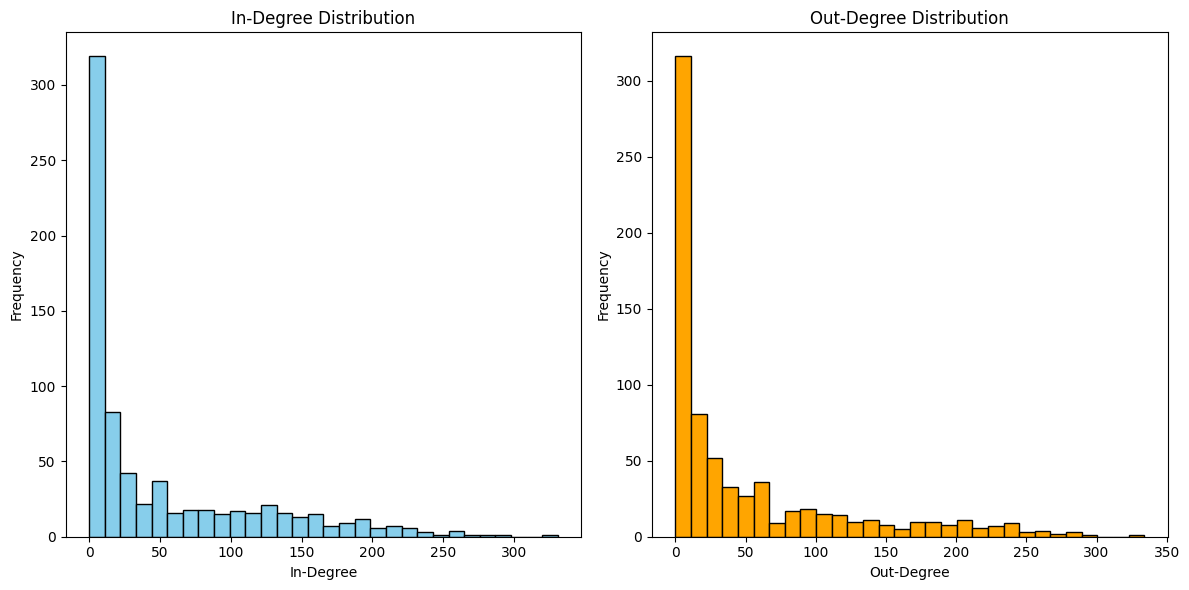

Number of Airports (Nodes): 727
Number of Flights (Edges): 36719
Graph Density: 0.0695696492245198
The graph is sparse.
Airports identified as hubs: ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'RNO', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'MIA', 'TPA', 'DAL', 'JAX']
    Hub  Degree              City
56  YIP     665       Detroit, MI
30  MSP     583   Minneapolis, MN
34  MEM     564       Memphis, TN
47  ATL     539       Atlanta, GA
28  MCI     539   Kansas City, MO
..  ...     ...               ...
57  LGA     335      New York, NY
42  FWA     332    Fort Wayne, IN
55  GRR     327  Grand Rapids, MI

In [53]:
analyze_graph_features(flight_graph)

Both graphs have a long tail, this shows that few airports have a high number of connections whereas most of the airports have few connections.<br>
This is a common fact in flight networks since bigger airports act as hub in order to concentrate the air traffic.<br>
The low density of the graph is a conseguence of this fact.

---

## Summarize Graph Features

In [54]:
def summarize_graph_features(flight_network):
    # Create a lookup dictionary for airport-to-city mapping
    airport_to_city = df.set_index('Origin_airport')['Origin_city'].to_dict()
    
    # Number of nodes and edges
    num_nodes = nx.number_of_nodes(flight_network)
    num_edges = nx.number_of_edges(flight_network)
    
    # Graph density
    density = ( num_edges) / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0
    
    # Degree distributions
    in_degrees = list(dict(flight_network.in_degree()).values())
    out_degrees = list(dict(flight_network.out_degree()).values())
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(in_degrees, bins=20)
    plt.title("In-Degree Distribution")
    plt.subplot(1, 2, 2)
    plt.hist(out_degrees, bins=20)
    plt.title("Out-Degree Distribution")
    plt.tight_layout()
    plt.show()
    
    # Identify hubs (we take only top5)
    hub_nodes = sorted(dict(flight_network.out_degree()).items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Graph density: {density:.3f}")
    
    print("\nTop 5 hubs:")
    
    for node, degree in hub_nodes:
        # Get the city associated with the airport, defaulting to "Unknown" if not found
        city = airport_to_city.get(node, "Unknown")
        print(f"- Node {node} ({city}): {degree} outgoing edges")

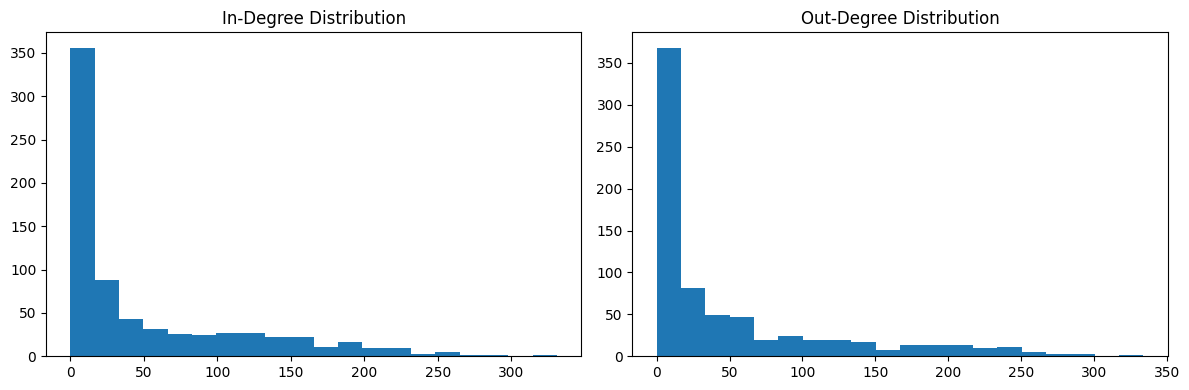

Number of nodes: 727
Number of edges: 36719
Graph density: 0.070

Top 5 hubs:
- Node YIP (Detroit, MI): 334 outgoing edges
- Node MSP (Minneapolis, MN): 292 outgoing edges
- Node MEM (Memphis, TN): 287 outgoing edges
- Node ORD (Chicago, IL): 286 outgoing edges
- Node ATL (Atlanta, GA): 280 outgoing edges


In [55]:
summarize_graph_features(flight_graph)

---

## Deeper Analysis Of The Dataset

**Firstly we show the busiest routes in term of passengers traffic**

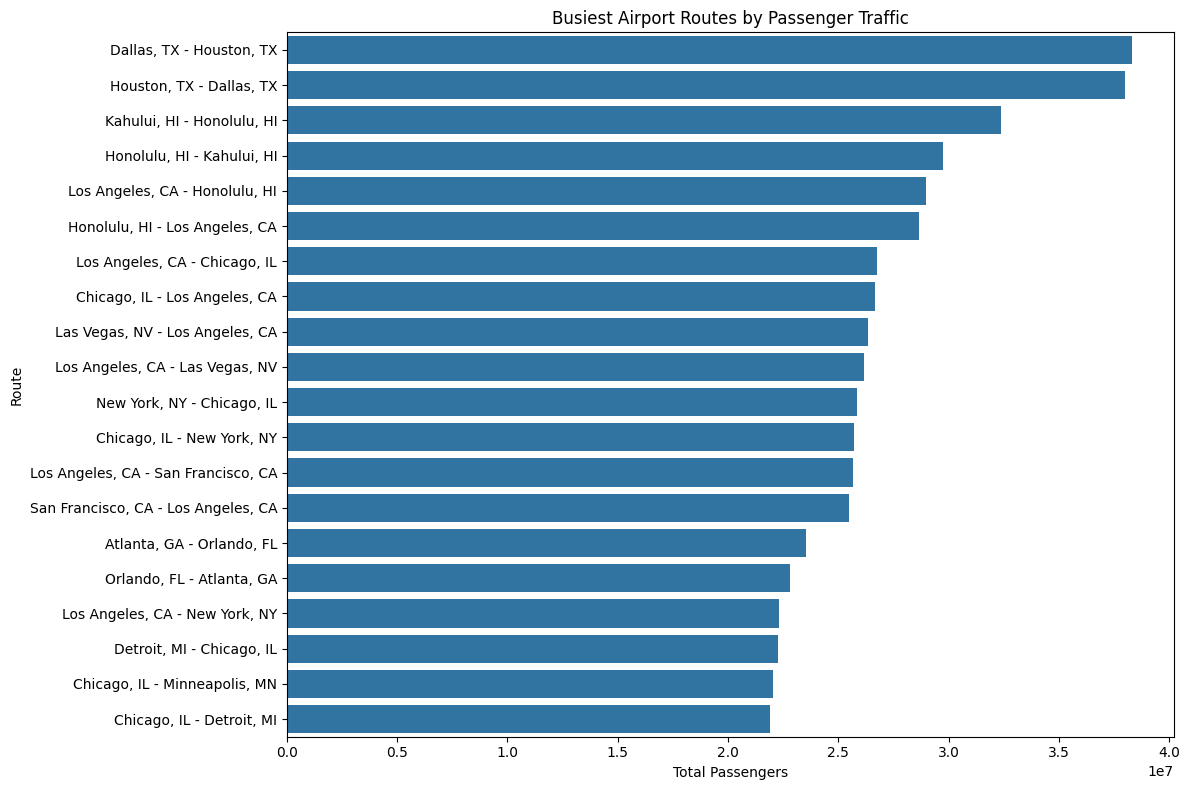

In [52]:
# Calculate total passenger flow between city pairs
city_pairs = df[['Origin_city', 'Destination_city', 'Passengers']].groupby(['Origin_city', 'Destination_city']).sum().reset_index()
city_pairs = city_pairs.sort_values('Passengers', ascending=False)

# Create a new column with the combined city names
city_pairs['Route'] = city_pairs['Origin_city'] + ' - ' + city_pairs['Destination_city']

# Visualize the busiest routes
plt.figure(figsize=(12, 8))
sns.barplot(x='Passengers', y='Route', data=city_pairs[:20])
plt.title('Busiest Airport Routes by Passenger Traffic')
plt.xlabel('Total Passengers')
plt.ylabel('Route')
plt.tight_layout()

In [73]:
city_pairs[:20]

,Origin_city,Destination_city,Passengers,Route
7122,"Dallas, TX","Houston, TX",38295025,"Dallas, TX - Houston, TX"
12391,"Houston, TX","Dallas, TX",37989016,"Houston, TX - Dallas, TX"
13585,"Kahului, HI","Honolulu, HI",32364664,"Kahului, HI - Honolulu, HI"
12259,"Honolulu, HI","Kahului, HI",29744742,"Honolulu, HI - Kahului, HI"
16133,"Los Angeles, CA","Honolulu, HI",28964232,"Los Angeles, CA - Honolulu, HI"
12264,"Honolulu, HI","Los Angeles, CA",28632161,"Honolulu, HI - Los Angeles, CA"
16083,"Los Angeles, CA","Chicago, IL",26751937,"Los Angeles, CA - Chicago, IL"
5323,"Chicago, IL","Los Angeles, CA",26645096,"Chicago, IL - Los Angeles, CA"
15218,"Las Vegas, NV","Los Angeles, CA",26333721,"Las Vegas, NV - Los Angeles, CA"
16152,"Los Angeles, CA","Las Vegas, NV",26177809,"Los Angeles, CA - Las Vegas, NV"


**Then we proceed by showing the most/least-utilized connections.**

In [24]:
# Calculate average passengers per flight for each route
route_efficiency = df[['Origin_city', 'Destination_city', 'Passengers', 'Flights']].groupby(['Origin_city', 'Destination_city']).agg({'Passengers': 'sum', 'Flights': 'sum'}).reset_index()
route_efficiency['Avg_Passengers_per_Flight'] = route_efficiency['Passengers'] / route_efficiency['Flights']

# Sort them in order to easily identify most/least efficient connections
route_efficiency = route_efficiency.sort_values('Avg_Passengers_per_Flight')



---


### Let's clean the data

In [25]:

# Drop rows with missing values
route_efficiency = route_efficiency.dropna()

# Or fill missing values
route_efficiency = route_efficiency.fillna(0)

route_efficiency = route_efficiency.astype({'Passengers': 'int', 'Flights': 'int'})

route_efficiency = route_efficiency[(route_efficiency['Passengers'] > 0) & (route_efficiency['Flights'] > 0)]

---

In [26]:
#top 10 most efficient
route_efficiency.head(10)

,Origin_city,Destination_city,Passengers,Flights,Avg_Passengers_per_Flight
28859,"Visalia, CA","Oakland, CA",7,3441,0.002034
23571,"Rock Springs, WY","Casper, WY",6,2216,0.002708
334,"Albany, NY","Memphis, TN",5,1767,0.002830
20885,"Parkersburg, WV","Columbus, OH",2,402,0.004975
4166,"Casper, WY","Scottsbluff, NE",10,2004,0.004990
23247,"Riverton, WY","Casper, WY",9,1512,0.005952
23604,"Rockford, IL","Boston, MA",2,299,0.006689
12102,"Hays, KS","Wichita, KS",2,271,0.007380
4162,"Casper, WY","Rock Springs, WY",28,3765,0.007437
16678,"Manchester, NH","Memphis, TN",31,4076,0.007605


In [27]:
#top 10 least utilized
route_efficiency.tail(10)

,Origin_city,Destination_city,Passengers,Flights,Avg_Passengers_per_Flight
12279,"Honolulu, HI","Omaha, NE",1063,3,354.333333
14288,"Knoxville, TN","Fresno, CA",355,1,355.000000
29084,"Washington, DC","Honolulu, HI",362,1,362.000000
12225,"Honolulu, HI","Billings, MT",377,1,377.000000
17005,"Medford, OR","Topeka, KS",378,1,378.000000
26996,"St. Louis, MO","Moses Lake, WA",380,1,380.000000
12281,"Honolulu, HI","Oshkosh, WI",395,1,395.000000
23844,"Roswell, NM","New York, NY",421,1,421.000000
12284,"Honolulu, HI","Pittsburgh, PA",426,1,426.000000
21693,"Pittsburgh, PA","Honolulu, HI",426,1,426.000000


**Attention:** Most of the above connections have only 1 flight, this data has a big influence on the analysis since it conveys only information about a specific flight and not a route. 

In [28]:
# Identify most efficient connections with more than 10 flights
most_efficient = route_efficiency[(route_efficiency['Flights'] > 10)].tail(10)
most_efficient

,Origin_city,Destination_city,Passengers,Flights,Avg_Passengers_per_Flight
12222,"Honolulu, HI","Atlanta, GA",1727637,6979,247.547930
24300,"Salt Lake City, UT","Honolulu, HI",766018,3055,250.742390
12260,"Honolulu, HI","Kansas City, MO",3561,14,254.357143
2317,"Bangor, ME","Orlando, FL",1115347,4371,255.169755
12301,"Honolulu, HI","St. Louis, MO",1202557,4635,259.451348
17956,"Minneapolis, MN","Honolulu, HI",1359279,5239,259.453903
26944,"St. Louis, MO","Honolulu, HI",1142259,4390,260.195672
12270,"Honolulu, HI","Minneapolis, MN",1365628,5235,260.864947
16062,"Los Angeles, CA","Bangor, ME",25737,91,282.824176
2294,"Bangor, ME","Los Angeles, CA",26600,80,332.500000


This second table gives a more truthful information about the most over utilized routes.

In [29]:
#This will help us for the visualization: 
#I create a new coloumn with the route so when I plot it easier to understand.
route_efficiency['Route'] = route_efficiency['Origin_city'] + ' - ' + route_efficiency['Destination_city']
most_efficient['Route'] = most_efficient['Origin_city'] + ' - ' + most_efficient['Destination_city']

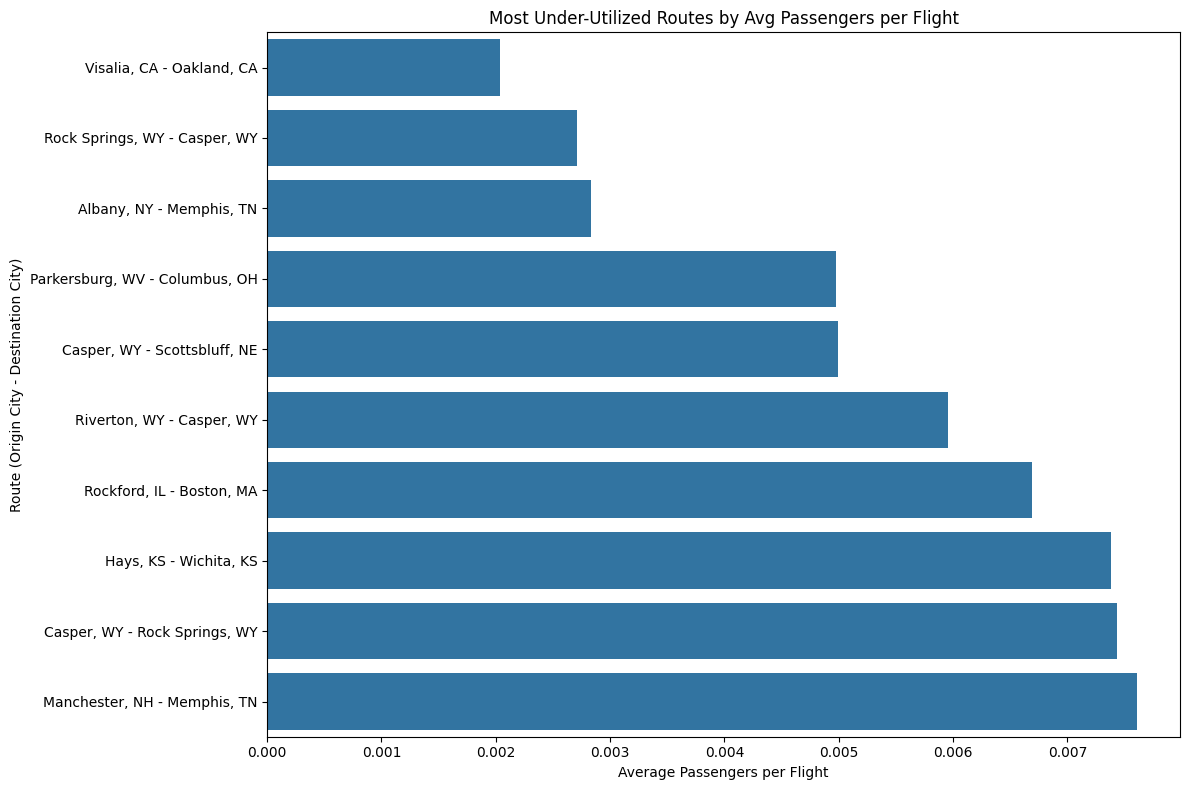

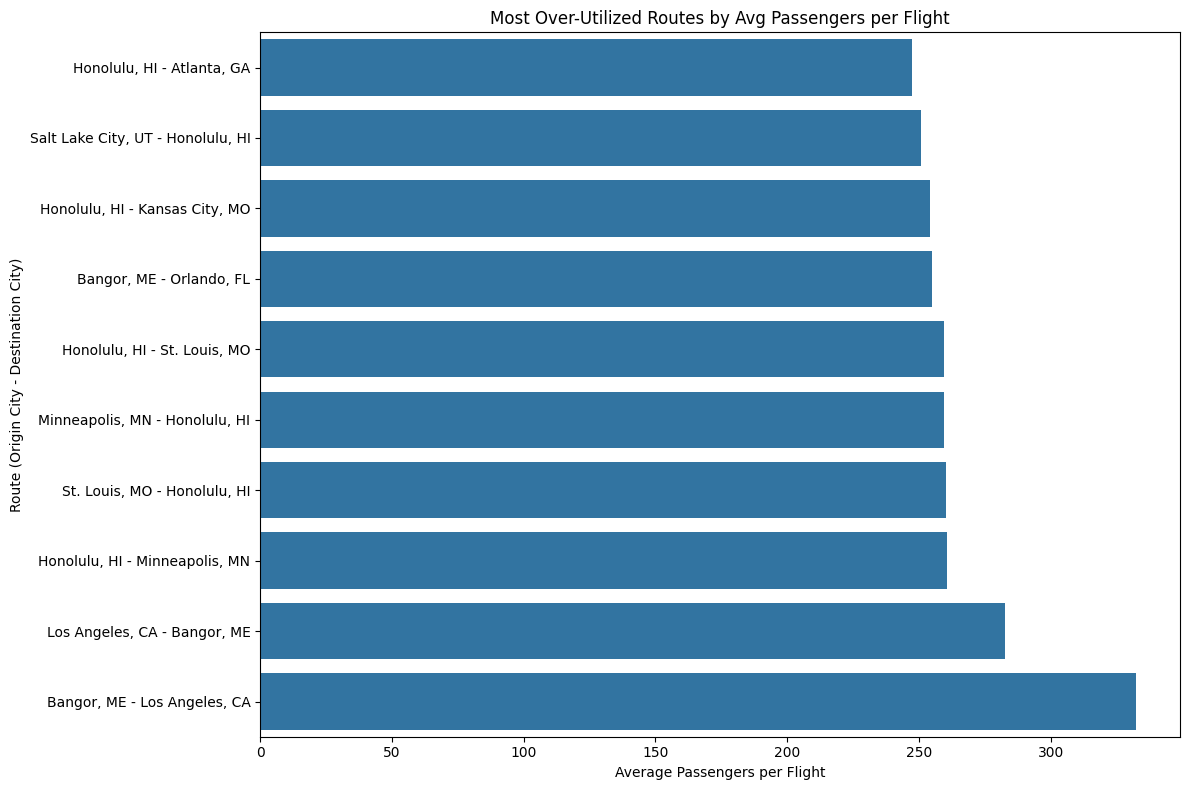

In [30]:

# Top 10 most under-utilized routes (lowest Avg_Passengers_per_Flight)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Avg_Passengers_per_Flight',
    y='Route',
    data=route_efficiency.head(10)
)
plt.title('Most Under-Utilized Routes by Avg Passengers per Flight')
plt.xlabel('Average Passengers per Flight')
plt.ylabel('Route (Origin City - Destination City)')
plt.tight_layout()
plt.show()

# Top 10 most over-utilized routes (highest Avg_Passengers_per_Flight)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Avg_Passengers_per_Flight',
    y='Route' ,
    data=most_efficient
)
plt.title('Most Over-Utilized Routes by Avg Passengers per Flight')
plt.xlabel('Average Passengers per Flight')
plt.ylabel('Route (Origin City - Destination City)')
plt.tight_layout()
plt.show()

Here above we can see the **routes** with rispectively the lower and higher number of **average passengers per flight**.

---


Now let's analyze the **over/under utilized** routes.<br>
In order to do so we need to calculate the relationship between the passengers and the available seats for each route.

In [41]:
route_stats = df[['Origin_city', 'Destination_city', 'Passengers', 'Seats', 'Flights']].groupby(['Origin_city', 'Destination_city']).agg({'Passengers': 'sum','Seats': 'sum', 'Flights':'sum'}).reset_index()

#Calculate Seat Utilization and store the value in a new column.
route_stats['Seat_Utilization'] = route_stats['Passengers'] / route_stats['Seats']
#Sort by Seat Utilization
route_stats=route_stats.sort_values(by='Seat_Utilization', ascending=False)


In [42]:
#We clean the data just in case.
# Drop rows with missing values
route_stats = route_stats.dropna()

# Or fill missing values
route_stats = route_stats.fillna(0)

route_stats = route_stats.astype({'Passengers': 'int', 'Seats': 'int', 'Flights': 'int'})

route_stats = route_stats[(route_stats['Passengers'] > 0) & (route_stats['Seats'] > 0)]

In [43]:
over_utilized_routes = route_stats.head(10)
print("Top 10 Over-Utilized Routes:")
over_utilized_routes 


Top 10 Over-Utilized Routes:


,Origin_city,Destination_city,Passengers,Seats,Flights,Seat_Utilization
22606,"Raleigh, NC","Parkersburg, WV",60,59,1,1.016949
11730,"Harrisburg, PA","Augusta, GA",50,50,1,1.000000
548,"Albuquerque, NM","Springfield, IL",131,131,1,1.000000
8323,"Eau Claire, WI","Abilene, TX",124,124,1,1.000000
29258,"Waterloo, IA","Longview, TX",84,84,1,1.000000
18949,"Nashville, TN","Erie, PA",100,100,1,1.000000
8855,"Erie, PA","Scranton, PA",50,50,1,1.000000
29119,"Washington, DC","Mason City, IA",486,486,3,1.000000
7157,"Dallas, TX","Lynchburg, VA",50,50,1,1.000000
22496,"Raleigh, NC","Brunswick, GA",50,50,1,1.000000


9 out of 10 routes here have only had 1 flight, this analysis can be misleading, or better, it does not properly convey significant information about routes but more about those specific flights. In order for our reader to have also a more open prospective on over utilized routes we will present a second result considering only routes with more than 10 flights.<br>

For some reasons the flight from Raleigh,NC to Parkersburg, WV results having a passenger more than its seats. Since it is not disproportional we decided to include it because we feel it does not falsify our analysis.

In [46]:
more_than_ten=route_stats[(route_stats['Flights'] >10)].head(10)
print("Top 10 Over-Utilized Routes with more than 10 Flights:")
more_than_ten 

Top 10 Over-Utilized Routes with more than 10 Flights:


,Origin_city,Destination_city,Passengers,Seats,Flights,Seat_Utilization
24083,"Saginaw, MI","Shreveport, LA",56,56,39,1.000000
17192,"Memphis, TN","Portland, ME",50,50,1837,1.000000
10088,"Fort Wayne, IN","Los Angeles, CA",379,380,1421,0.997368
16117,"Los Angeles, CA","Fort Wayne, IN",354,355,1729,0.997183
14947,"Laredo, TX","Detroit, MI",224,225,940,0.995556
947,"Anchorage, AK","Dayton, OH",181,183,142,0.989071
25783,"Seattle, WA","Fort Wayne, IN",178,180,971,0.988889
17151,"Memphis, TN","Manchester, NH",172,174,4095,0.988506
2151,"Baltimore, MD","Ocala, FL",172,174,31,0.988506
10950,"Great Falls, MT","Casper, WY",148,150,24,0.986667


In [44]:
under_utilized_routes = route_stats.tail(10)
print("\nTop 10 Under-Utilized Routes:")
under_utilized_routes


Top 10 Under-Utilized Routes:


,Origin_city,Destination_city,Passengers,Seats,Flights,Seat_Utilization
17303,"Merced, CA","Sacramento, CA",2,784,12,0.002551
23604,"Rockford, IL","Boston, MA",2,840,299,0.002381
23274,"Roanoke, VA","Buffalo, NY",1,486,5,0.002058
8221,"Duluth, MN","Durango, CO",30,15100,1,0.001987
23681,"Rockford, IL","Memphis, TN",1,516,106,0.001938
27458,"Syracuse, NY","Youngstown, OH",1,608,5,0.001645
17456,"Miami, FL","Lafayette, IN",2,1224,8,0.001634
17287,"Merced, CA","Los Angeles, CA",1,625,12,0.001600
28925,"Waco, TX","New York, NY",1,768,4,0.001302
5976,"Clovis, NM","Hobbs, NM",7,6403,337,0.001093


Some of the results we get from the under-utilized routes do not look real.<br> Doing a small research here: https://www.travel365.it/classifica-aerei-piu-grandi-del-mondo.htm we found out that nowadays the biggest airliners can take up to 850 passengers, therefore the number of seats for the flight Duluth-->Durango is wrong.<br> Must be observed, moreover, that most of the routes were still active even though the number of passengers was incredibly scarse. Honestly we do not believe that companies would have allowed planes to fly empty. This is why this output does not give us a feeling of truth. Anyway this is what we got, a possible solution would be setting a threshold and only considering flights with at least a certain percentage of seat utilization.

---
# Interactive Map


In [57]:
pip install folium

  Using cached xyzservices-2024.9.0-py3-none-any.whl.metadata (4.1 kB)
Using cached xyzservices-2024.9.0-py3-none-any.whl (85 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Need to clean the data
df = df.dropna(subset=['Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'])
df['Org_airport_lat'].fillna(0, inplace=True)
df['Org_airport_long'].fillna(0, inplace=True)
df['Dest_airport_lat'].fillna(0, inplace=True)
df['Dest_airport_long'].fillna(0, inplace=True)

/var/folders/tx/0r7d70vd1r5fj6hhc8kdkh680000gn/T/ipykernel_28192/1899558232.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Org_airport_lat'].fillna(0, inplace=True)
/var/folders/tx/0r7d70vd1r5fj6hhc8kdkh680000gn/T/ipykernel_28192/1899558232.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [4]:
import folium
import pandas as pd

def create_flight_network_map(df, map_center=[39.8283, -98.5795], zoom_start=4, output_file="flight_network_map.html", sample_size=100):
    """
    Creates a flight network map from a DataFrame containing airport information.
    
    Parameters:
        df (pd.DataFrame): DataFrame with the following columns:
            - 'Origin_airport', 'Org_airport_lat', 'Org_airport_long'
            - 'Destination_airport', 'Dest_airport_lat', 'Dest_airport_long'
        map_center (list): Latitude and longitude to center the map in the US.
        zoom_start (int): Initial zoom level of the map.
        output_file (str): File name to save the HTML map.
        sample_size (int): Number of rows to sample from the DataFrame.

    Returns:
        None. Saves the map to an HTML file.
    """
    # Sample the DataFrame
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Sampled {sample_size} routes from the original DataFrame.")

    # Initialize the map
    flight_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Combine Origin and Destination airports into a single DataFrame
    airports = pd.concat([
        df[["Origin_airport", "Org_airport_lat", "Org_airport_long"]].rename(
            columns={"Origin_airport": "Airport", "Org_airport_lat": "Latitude", "Org_airport_long": "Longitude"}
        ),
        df[["Destination_airport", "Dest_airport_lat", "Dest_airport_long"]].rename(
            columns={"Destination_airport": "Airport", "Dest_airport_lat": "Latitude", "Dest_airport_long": "Longitude"}
        ),
    ])

    # Remove duplicates to avoid redundant markers
    unique_airports = airports.drop_duplicates(subset=["Airport", "Latitude", "Longitude"])

    # Add markers for each unique airport
    for _, row in unique_airports.iterrows():
        folium.Marker(
            location=(row["Latitude"], row["Longitude"]),
            popup=f"Airport: {row['Airport']}",
            icon=folium.Icon(color='blue', icon='plane')
        ).add_to(flight_map)

    # Add edges (routes) between Origin and Destination airports
    for _, row in df.iterrows():
        folium.PolyLine(
            locations=[
                (row["Org_airport_lat"], row["Org_airport_long"]),  # Origin coordinates
                (row["Dest_airport_lat"], row["Dest_airport_long"])  # Destination coordinates
            ],
            color="blue",
            weight=2,  # Line weight
            opacity=0.7,  # Line transparency
            tooltip=f"Route: {row['Origin_airport']} to {row['Destination_airport']}"
        ).add_to(flight_map)

    # Save the map to an HTML file
    flight_map.save(output_file)
    print(f"Map has been saved as {output_file}. Open this file in your browser to view it.")

In [5]:
create_flight_network_map(df)

Sampled 100 routes from the original DataFrame.
Map has been saved as flight_network_map.html. Open this file in your browser to view it.


![Example_of_map](Example_map.png)

We decided to only show a small part of the routes in order to make the image more readable. 

---

## Answer Questions:

-**Graph Density**: The graph density is around 0.07, this means that approximately 7% of all possible edges are present in the graph. Thus the graph is relatively sparse.<br>
-**Degree Distribution**:A really small number of nodes have a very high degree, and a large number of nodes have a low degree.<br>
-**Hubs**: 
Airports identified as hubs: ['SEA', 'PDX', 'SFO', 'LAX', 'FLL', 'PHX', 'TUS', 'DFW', 'SLC', 'RNO', 'ABQ', 'LAS', 'ICT', 'OKC', 'SAN', 'OAK', 'IAH', 'ELP', 'TUL', 'OMA', 'AUS', 'COS', 'MSN', 'RFD', 'MKE', 'DSM', 'LIT', 'SHV', 'MCI', 'SAT', 'MSP', 'ORD', 'STL', 'BNA', 'MEM', 'IND', 'LRD', 'CLE', 'DTW', 'DAY', 'CVG', 'CMH', 'FWA', 'HOU', 'TOL', 'PIT', 'BOS', 'ATL', 'MDW', 'PHL', 'GSO', 'BUF', 'EWR', 'CLT', 'JFK', 'GRR', 'YIP', 'LGA', 'LEX', 'BHM', 'MCO', 'IAD', 'MSY', 'RDU', 'GSP', 'BDL', 'CAE', 'BWI', 'TYS', 'MIA', 'TPA', 'DAL', 'JAX']<br>
-For **Busiest Routes** and **Under/Over-Utilized routes** take a look at the tables presented above.<br>